In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso, Ridge
import seaborn as sns

In [2]:
data=pd.read_csv('flight_delay.csv')


# Airports One-Hot-Encoding

In [4]:
data['way']=data['Depature Airport']+'-'+data['Destination Airport']

In [5]:
airports_way_dict={}
count=101
for i in data['way']:
    if i in airports_way_dict.keys():
        pass
    else:
        airports_way_dict[i]=count
        count+=1

In [6]:
dict_for_repalce_way={'way': airports_way_dict}

In [7]:
data=data.replace(dict_for_repalce_way)

In [9]:
#len(data['Depature Airport'].unique()) # Output is '179'

In [10]:
airports_dict={}
count=1
for i in data['Depature Airport']:
    if i in airports_dict.keys():
        pass
    else:
        airports_dict[i]=count
        count+=1

In [11]:
dict_for_repalce={'Depature Airport': airports_dict}

In [12]:
data=data.replace(dict_for_repalce)

In [13]:
airports_dict['DME']=180

In [14]:
dict_for_repalce={'Destination Airport': airports_dict}

In [15]:
data=data.replace(dict_for_repalce)

# Flight duration in minutes

In [16]:
data['Dep_datetime'] = pd.to_datetime(data['Scheduled depature time'])

In [17]:
data['Arrival_datetime']= pd.to_datetime(data['Scheduled arrival time'])

In [18]:
q=data['Arrival_datetime']-data['Dep_datetime']

In [19]:
data['flight duration'] = q.dt.total_seconds().div(60).astype(int)

# Departure day of week  

In [20]:
temp_arr=[]
def date_info(dt):
    
    year, month, day = (int(x) for x in dt.split('-'))  
    ans = datetime.date(year, month, day)
    temp_arr.append(ans.strftime("%A"))
for i in data['Dep_datetime']:
    i=str(i)
    date_info(i.split(' ')[0])

In [21]:
data['day of week']=pd.DataFrame(temp_arr)

In [22]:
days={'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}

In [23]:
day_of_week={'day of week':days}

In [24]:
data=data.replace(day_of_week)

In [25]:
day_or_night=[]
for i in data['Dep_datetime']:
    if 5<int(str(i).split(' ')[1].split(':')[0])<22:
        day_or_night.append(1)
    else:
        day_or_night.append(0)

In [26]:
data['daytime']=pd.DataFrame(day_or_night)

# SEASON

In [27]:
months=[]
for i in data['Scheduled depature time']: 
    if int(str(i).split(' ')[0].split('-')[1])==12 or int(str(i).split(' ')[0].split('-')[1])<=2:
        months.append(1) # Winter
    elif 3<=int(str(i).split(' ')[0].split('-')[1])<=5:
        months.append(2) # Spring
    elif 6<=int(str(i).split(' ')[0].split('-')[1])<=8:
        months.append(3) # Summer
    elif 9<=int(str(i).split(' ')[0].split('-')[1])<=11:
        months.append(4) # Fall

data['season']=pd.DataFrame(months)

# Years

In [28]:
years=[]
for i in data['Scheduled depature time']:
    years.append(i.split(' ')[0].split('-')[0])
data['years']=pd.DataFrame(years)

# Drop columns

In [29]:
data=data.drop(columns=['Scheduled depature time','Scheduled arrival time','Dep_datetime','Arrival_datetime'])

In [30]:
X=data.drop(columns='Delay')

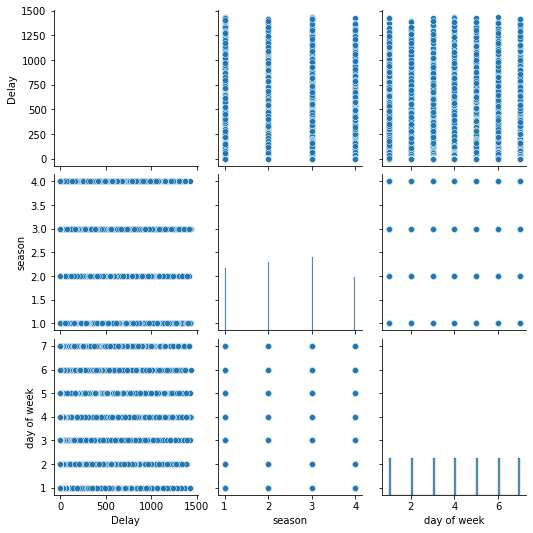

In [31]:
sns.pairplot(data[['Delay','season','day of week']])

Text(0.5, 0, 'Flight Duration')

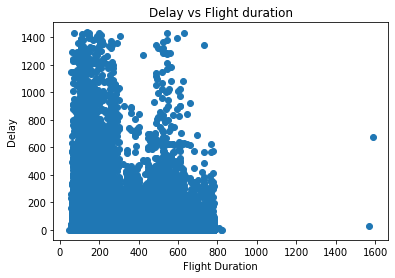

In [34]:
plt.scatter(data['flight duration'],data['Delay'])
plt.title('Delay vs Flight duration')
plt.ylabel('Delay')
plt.xlabel('Flight Duration')

In [35]:
from sklearn.decomposition import PCA

In [36]:
pca = PCA(n_components=2)

In [37]:
pca.fit(X)

PCA(n_components=2)

In [38]:
data_pca=pca.transform(X)

In [39]:
data_pca

array([[ 578.02764348, -157.78756733],
       [ 438.74441105, -144.6640356 ],
       [ 563.58736752, -154.22231596],
       ...,
       [ -90.22478395,  214.31123622],
       [   7.69679595,   22.71156019],
       [ 136.48322577, -104.50998708]])

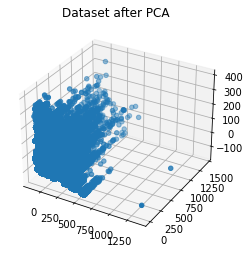

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca[:, 0],data['Delay'],data_pca[:,1])
plt.title('Dataset after PCA')

plt.show()

# Split Data

In [41]:
test_data=data

In [42]:
data=data.drop(data[data.years.astype(int)>2017].index)

In [43]:
test_data=test_data.drop(test_data[test_data.years.astype(int)<=2017].index)

In [44]:
data.corr()

,Depature Airport,Destination Airport,Delay,way,flight duration,day of week,daytime,season
Depature Airport,1.000000,-0.493830,0.042693,0.561410,0.152706,0.001274,-0.160059,0.009254
Destination Airport,-0.493830,1.000000,-0.010415,0.152348,0.143421,0.002981,0.039155,0.009767
Delay,0.042693,-0.010415,1.000000,0.029552,0.043671,0.005237,-0.021983,-0.027962
way,0.561410,0.152348,0.029552,1.000000,0.085641,0.003219,-0.133557,0.026832
flight duration,0.152706,0.143421,0.043671,0.085641,1.000000,0.003986,-0.023129,-0.005308
day of week,0.001274,0.002981,0.005237,0.003219,0.003986,1.000000,-0.000248,-0.003695
daytime,-0.160059,0.039155,-0.021983,-0.133557,-0.023129,-0.000248,1.000000,0.001842
season,0.009254,0.009767,-0.027962,0.026832,-0.005308,-0.003695,0.001842,1.000000


# Outliers


In [45]:
delay=data['Delay']

In [46]:
mean=np.mean(delay)


In [47]:
std=np.std(delay)


In [48]:
threshold = 2
outliers = []
out=[]
for i in delay:
    
    z = (i-mean)/std
    if z > threshold:
        outliers.append(99999)
        out.append(i)
    else:
        outliers.append(i)



In [49]:
data['outliers']=pd.DataFrame(outliers)

In [50]:
#data['outliers'].isnull().sum() # Output is '3'

# Remove outliers

In [51]:
data=data.drop(data[data.outliers==99999].index)

In [52]:
#data['outliers'].isnull().sum() # Output is still '3'

In [53]:
# data.tail() # last 3 rows with Nan in data['outliers']

In [54]:
data=data.drop([499164,499168,499535])

In [55]:
#data['outliers'].isnull().sum() # Output is '0'

In [56]:
data=data.drop(['outliers'],axis=1)

# train data and test data

In [57]:
y_train=data['Delay']

In [58]:
data=data.drop(['Delay','years'],axis=1)

In [59]:
y_test=test_data['Delay']

In [60]:
X_test=test_data.drop(['Delay','years'],axis=1)

# Linear regression

In [61]:
regression=LinearRegression()

In [68]:
lin_reg=regression.fit(data,y_train)

In [69]:
lin_reg_pred=lin_reg.predict(X_test)

In [70]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lin_reg_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lin_reg_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lin_reg_pred)))

Mean Absolute Error: 10.753394059183634
Mean Squared Error: 1594.5397470873058
Root Mean Squared Error: 39.93168850784181


# Polynomial regression

In [71]:
#train data
degrees = [1, 2, 3]

for i in degrees:

    poly_feat = PolynomialFeatures(degree=i)
    lin_reg = LinearRegression()
    pipeline = Pipeline([("polynomial_features", poly_feat),
                         ("linear_regression", lin_reg)])
    pipeline.fit(data, y_train)

    
    scores_mae = cross_val_score(pipeline, data, y_train, scoring="neg_mean_absolute_error", cv=8)
    scores_mse = cross_val_score(pipeline, data, y_train, scoring="neg_mean_squared_error", cv=8)
    scores_rmse = cross_val_score(pipeline, data, y_train, scoring="neg_root_mean_squared_error", cv=8)
    
    

    print("Degree {}\nMAE = {}".format(i, -scores_mae.mean()),'STD: ', scores_mae.std())
    print("Degree {}\nMSE = {}".format(i, -scores_mse.mean()),'STD: ', scores_mse.std())
    print("Degree {}\nRMSE = {}".format(i, -scores_rmse.mean()),'STD: ', scores_rmse.std())

Degree 1
MAE = 8.160720393087427 STD:  0.3037186064370316
Degree 1
MSE = 188.43714055896587 STD:  21.539543431694486
Degree 1
RMSE = 13.704562371658652 STD:  0.7887399826835658
Degree 2
MAE = 8.127871331663332 STD:  0.4137275371868178
Degree 2
MSE = 188.06931042652974 STD:  21.355570455334583
Degree 2
RMSE = 13.691325910673653 STD:  0.7854331507175044
Degree 3
MAE = 8.075786296119539 STD:  0.6289932334657743
Degree 3
MSE = 186.52358078636422 STD:  22.2496043664491
Degree 3
RMSE = 13.6324233376201 STD:  0.8249937759008048


In [72]:
#test data
degrees = [1, 2, 3]

for i in degrees:

    poly_feat = PolynomialFeatures(degree=i)
    lin_reg = LinearRegression()
    pipeline = Pipeline([("polynomial_features", poly_feat),
                         ("linear_regression", lin_reg)])
    pipeline.fit(data, y_train)

    
    scores_mae = cross_val_score(pipeline, X_test, y_test, scoring="neg_mean_absolute_error", cv=5)
    scores_mse = cross_val_score(pipeline, X_test, y_test, scoring="neg_mean_squared_error", cv=5)
    scores_rmse = cross_val_score(pipeline, X_test, y_test, scoring="neg_root_mean_squared_error", cv=5)
    
    

    print("Degree {}\nMAE = {}".format(i, -scores_mae.mean()),'STD: ', scores_mae.std())
    print("Degree {}\nMSE = {}".format(i, -scores_mse.mean()),'STD: ', scores_mse.std())
    print("Degree {}\nRMSE = {}".format(i, -scores_rmse.mean()),'STD: ', scores_rmse.std())

Degree 1
MAE = 10.000941364268247 STD:  4.4223592464417125
Degree 1
MSE = 1594.9134169259473 STD:  1014.5757438578436
Degree 1
RMSE = 38.096068188644345 STD:  11.983447145629984
Degree 2
MAE = 9.746905233322206 STD:  4.216758491050873
Degree 2
MSE = 1585.8979089938828 STD:  1006.4521159461652
Degree 2
RMSE = 37.99162075788349 STD:  11.938788095239802
Degree 3
MAE = 10.353361966135079 STD:  3.769513784495682
Degree 3
MSE = 2856.23698370335 STD:  2359.6016037816344
Degree 3
RMSE = 49.16393167838499 STD:  20.95578215258123


# Lasso

In [73]:
alphas=[]
for i in range(15):
    alphas.append(1000/(10**i))


In [74]:
MAE_list=[]
MSE_list=[]
RMSE_list=[]

for i in alphas:
    lasso = Lasso(alpha=i)
    lasso.fit(data, y_train)
    prediction = lasso.predict(X_test)
    
    mae = metrics.mean_absolute_error(y_test, prediction)
    mse = metrics.mean_squared_error(y_test, prediction)
    rmse = math.sqrt(metrics.mean_squared_error(y_test, prediction))
    
    MAE_list.append(mae)
    MSE_list.append(mse)
    RMSE_list.append(rmse)
    
best_alpha_mae = alphas[np.argmin(MAE_list)]
min_arg_mae=min(MAE_list)

index=alphas.index(best_alpha_mae)

min_arg_mse=MSE_list[index]
min_arg_rmse=RMSE_list[index]

print("Best value of alpha:", best_alpha_mae,'\nMAE= ',min_arg_mae,
      '\nMSE= ',min_arg_mse,'\nRMSE= ',min_arg_rmse)


Best value of alpha: 1.0 
MAE=  10.672704685052896 
MSE=  1596.9486905658903 
RMSE=  39.961840430164


# Ridge

In [75]:
MAE_list=[]
MSE_list=[]
RMSE_list=[]
for i in alphas:
    lasso = Ridge(alpha=i)
    lasso.fit(data, y_train)
    prediction = lasso.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, prediction)
    mse = metrics.mean_squared_error(y_test, prediction)
    rmse = math.sqrt(metrics.mean_squared_error(y_test, prediction))
    
    MAE_list.append(mae)
    MSE_list.append(mse)
    RMSE_list.append(rmse)


best_alpha_mae = alphas[np.argmin(MAE_list)]
min_arg_mae=min(MAE_list)

index=alphas.index(best_alpha_mae)

min_arg_mse=MSE_list[index]
min_arg_rmse=RMSE_list[index]

print("Best value of alpha:", best_alpha_mae,'\nMAE= ',min_arg_mae,
      '\nMSE= ',min_arg_mse,'\nRMSE= ',min_arg_rmse)

Best value of alpha: 1000.0 
MAE=  10.753234229906793 
MSE=  1594.5416141706366 
RMSE=  39.931711886302054
